# 1. Preparacion y Carga

Metodo de importacion desde Google Drive

In [1]:
!pip install openmeteo-requests requests-cache retry-requests
!pip install airportsdata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.7/684.7 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.1/394.1 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 50.7 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 25.12.19
    Uninstalling flatbuffers-25.12.19:
      Successfully uninstalled flatbuffers-25.12.19
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.4/914.4 kB 12.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openmeteo_requests
import requests_cache
from retry_requests import retry
import airportsdata

url = "https://api.open-meteo.com/v1/forecast"
df = pd.read_csv('/content/drive/MyDrive/Datasets/2009.csv.zip')
df_2 = pd.read_csv('/content/drive/MyDrive/Datasets/DataSet 2019-2023.zip')
df_2.sample()


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
2422732,2021-07-31,Alaska Airlines Inc.,Alaska Airlines Inc.: AS,AS,19930,44,BET,"Bethel, AK",ANC,"Anchorage, AK",...,0.0,70.0,69.0,55.0,399.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
datasets = [df, df_2]

for df in datasets:
    df.columns = df.columns.str.lower().str.strip()


In [4]:
df.columns

Index(['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 27'],
      dtype='object')

In [5]:
df_2.columns

Index(['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE',
       'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DELAY_DUE_CARRIER',
       'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
       'DELAY_DUE_LATE_AIRCRAFT'],
      dtype='object')

In [6]:
df.shape

(6429338, 28)

In [7]:
df_2.shape

(3000000, 32)

#2. Concatenacion de los 3 Datasets



In [8]:
df_total = pd.concat([df, df_2], axis=0, ignore_index=True)

del df, df_2

print(f" Filas totales: {df_total.shape}")

 Filas totales: (9429338, 41)


#3. Variables de interes

- Para que nuestro modelo sea realista, predictivo y útil antes del
despegue, vamos a tratarlo con una mentalidad de "tiempo real".

- Si dejamos variables que se generan durante o después del vuelo, el modelo tendrá una precisión artificialmente alta en el entrenamiento

O segun el caso de uso tomaremos la decision de arquitectura entre:

 - (Predicción Temprana): Para predecir el retraso antes de que el avión salga de la puerta. Eliminamos **DepDelay.** Solo usaremos **Clima, Hora programada, Aerolínea y Origen.**

 - (Predicción en Tránsito): El avión ya despegó tarde y quieremos saber si recuperará tiempo en el aire. Mantén DepDelay.


Considerando que la Fuga de dato o DataLeakage es el asesino silencioso de los modelos de machine learning

In [9]:
variables_interes = ['FL_DATE', 'AIRLINE', 'ORIGIN', 'ORIGIN_CITY',
                     'CRS_DEP_TIME']
df_final = df_total[variables_interes]
df_final

,FL_DATE,AIRLINE,ORIGIN,ORIGIN_CITY,CRS_DEP_TIME
0,2009-01-01,NaN,DCA,NaN,1100
1,2009-01-01,NaN,EWR,NaN,1510
2,2009-01-01,NaN,EWR,NaN,1100
3,2009-01-01,NaN,DCA,NaN,1240
4,2009-01-01,NaN,IAD,NaN,1715
...,...,...,...,...,...
9429333,2022-11-13,American Airlines Inc.,JAX,"Jacksonville, FL",1742
9429334,2022-11-02,American Airlines Inc.,ORD,"Chicago, IL",1300
9429335,2022-09-11,Delta Air Lines Inc.,HSV,"Huntsville, AL",534
9429336,2019-11-13,Republic Airline,BOS,"Boston, MA",1600


In [10]:
df_final.isnull().sum()

,0
FL_DATE,0
AIRLINE,6429338
ORIGIN,0
ORIGIN_CITY,6429338
CRS_DEP_TIME,0


In [11]:
df_final.fillna(0)

,FL_DATE,AIRLINE,ORIGIN,ORIGIN_CITY,CRS_DEP_TIME
0,2009-01-01,0,DCA,0,1100
1,2009-01-01,0,EWR,0,1510
2,2009-01-01,0,EWR,0,1100
3,2009-01-01,0,DCA,0,1240
4,2009-01-01,0,IAD,0,1715
...,...,...,...,...,...
9429333,2022-11-13,American Airlines Inc.,JAX,"Jacksonville, FL",1742
9429334,2022-11-02,American Airlines Inc.,ORD,"Chicago, IL",1300
9429335,2022-09-11,Delta Air Lines Inc.,HSV,"Huntsville, AL",534
9429336,2019-11-13,Republic Airline,BOS,"Boston, MA",1600


In [12]:
df_final = df_final.fillna(0)
df_final.isnull().sum()

,0
FL_DATE,0
AIRLINE,0
ORIGIN,0
ORIGIN_CITY,0
CRS_DEP_TIME,0


In [13]:
df_final.dropna(axis=0, inplace=True)
df_final

,FL_DATE,AIRLINE,ORIGIN,ORIGIN_CITY,CRS_DEP_TIME
0,2009-01-01,0,DCA,0,1100
1,2009-01-01,0,EWR,0,1510
2,2009-01-01,0,EWR,0,1100
3,2009-01-01,0,DCA,0,1240
4,2009-01-01,0,IAD,0,1715
...,...,...,...,...,...
9429333,2022-11-13,American Airlines Inc.,JAX,"Jacksonville, FL",1742
9429334,2022-11-02,American Airlines Inc.,ORD,"Chicago, IL",1300
9429335,2022-09-11,Delta Air Lines Inc.,HSV,"Huntsville, AL",534
9429336,2019-11-13,Republic Airline,BOS,"Boston, MA",1600


In [14]:
df_final['FL_DATE'] = pd.to_datetime(df_final['FL_DATE'], errors='coerce')

In [21]:
df_final['FECHA_HORA'] = pd.to_datetime
df_final


ValueError: Length of values (2) does not match length of index (9429338)

In [22]:
df_final

,FL_DATE,AIRLINE,ORIGIN,ORIGIN_CITY,CRS_DEP_TIME,FECHA_HORA
0,2009-01-01,0,DCA,0,1100,2009-01-01 18:20:00
1,2009-01-01,0,EWR,0,1510,2009-01-02 01:10:00
2,2009-01-01,0,EWR,0,1100,2009-01-01 18:20:00
3,2009-01-01,0,DCA,0,1240,2009-01-01 20:40:00
4,2009-01-01,0,IAD,0,1715,2009-01-02 04:35:00
...,...,...,...,...,...,...
9429333,2022-11-13,American Airlines Inc.,JAX,"Jacksonville, FL",1742,2022-11-14 05:02:00
9429334,2022-11-02,American Airlines Inc.,ORD,"Chicago, IL",1300,2022-11-02 21:40:00
9429335,2022-09-11,Delta Air Lines Inc.,HSV,"Huntsville, AL",534,2022-09-11 08:54:00
9429336,2019-11-13,Republic Airline,BOS,"Boston, MA",1600,2019-11-14 02:40:00


In [ ]:
params = {
    "latitude": -34.1000,   # Latitud de Rancagua
    "longitude": -70.7000,  # Longitud de Rancagua
    "hourly": "temperature_2m",  # Datos a obtener
    "timezone": "auto"       # Zona horaria automática
    "variables_interes"
}

# Hacer la solicitud
response = requests.get(url, params=params)

# Verificar si la solicitud fue exitosa
if response.status_code == 200:

# Convertir los datos horarios a DataFrame
    df_final = pd.DataFrame(data["hourly"])
    data = response.json()
    print(df_final.head())  # Mostrar los primeros registros
else:
    print("Error al obtener datos:", response.status_code)

Error al obtener datos: 400


In [ ]:
df_final

,time,temperature_2m
0,2026-01-21T00:00,19.0
1,2026-01-21T01:00,18.3
2,2026-01-21T02:00,17.7
3,2026-01-21T03:00,16.9
4,2026-01-21T04:00,16.5
...,...,...
163,2026-01-27T19:00,30.4
164,2026-01-27T20:00,28.3
165,2026-01-27T21:00,26.1
166,2026-01-27T22:00,24.0


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25678 entries, 4109 to 9438397
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FL_DATE       25678 non-null  object 
 1   AIRLINE       25678 non-null  object 
 2   ORIGIN        25678 non-null  object 
 3   ORIGIN_CITY   25678 non-null  object 
 4   CRS_DEP_TIME  25678 non-null  object 
 5   LAT           25678 non-null  float64
 6   LON           25678 non-null  float64
dtypes: float64(2), object(5)
memory usage: 1.6+ MB


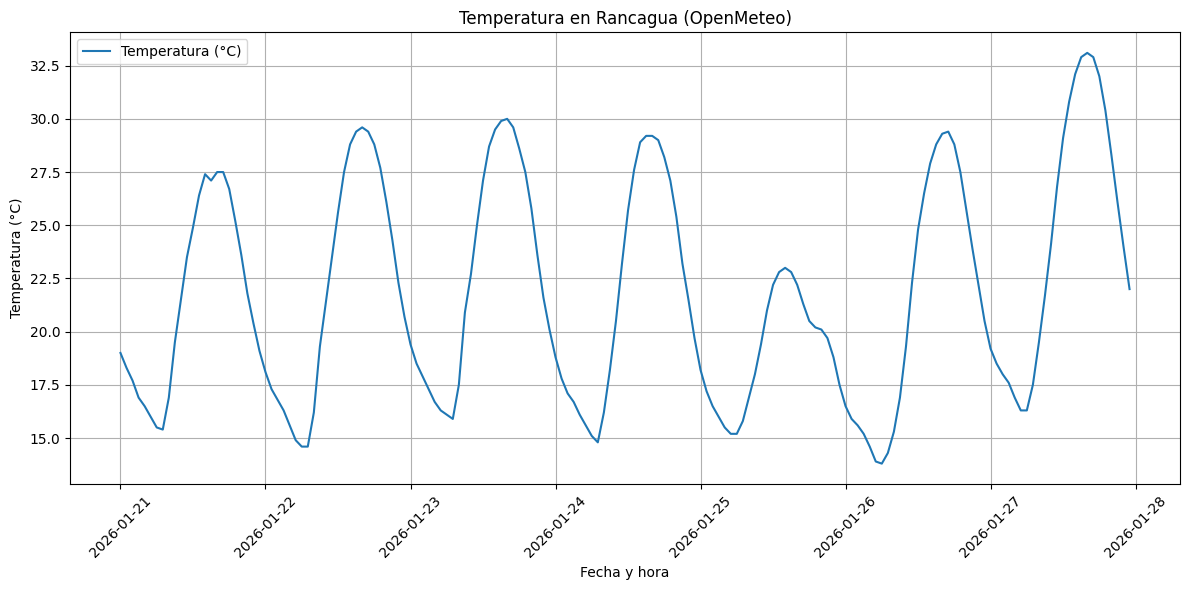

In [ ]:

# Convertir las fechas a formato datetime
df["time"] = pd.to_datetime(df["time"])

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df["time"], df["temperature_2m"], label="Temperatura (°C)")
plt.title("Temperatura en Rancagua (OpenMeteo)")
plt.xlabel("Fecha y hora")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Valores Nulos